# Imports e Configs

In [2]:
import os
os.environ["PYARROW_IGNORE_TIMEZONE"] = "1"
import sys
sys.path.append(os.path.abspath(".."))

from src.aux import read_parquet
import pandas as pd
import joblib
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
from tqdm.auto import tqdm
tqdm.pandas()
import ast
from scipy.stats import chi2_contingency, f_oneway, kruskal, pearsonr, spearmanr
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from skopt import gp_minimize
from skopt.space import Real, Integer
import tarfile
from pathlib import Path
import requests
import math

import warnings
warnings.filterwarnings("ignore")

import logging
logging.getLogger("py4j").setLevel(logging.ERROR)
logging.getLogger("pyspark").setLevel(logging.ERROR)


####################### PySparkSession ##############################
from pyspark.sql import SparkSession
spark = (
    SparkSession.builder
    .config("spark.sql.ansi.enabled", "false")
    .getOrCreate()
)
spark.sparkContext.setLogLevel("FATAL")

import pyspark.pandas as ps
from pyspark.sql.functions import to_date, col, datediff, lit

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
25/09/08 16:26:48 WARN Utils: Your hostname, juliopatti, resolves to a loopback address: 127.0.1.1; using 192.168.18.99 instead (on interface wlp62s0)
25/09/08 16:26:48 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/09/08 16:26:48 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/09/08 16:26:49 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


# Read dataset

In [3]:
folder = 'data/processed/gold'
df = read_parquet(f"../{folder}/ddf_agg.parquet").to_pandas()
print(df.shape)
df.head(2)

shape: (14820, 28)



<class 'pyspark.pandas.frame.DataFrame'>
Index: 14820 entries, 0 to 14819
Data columns (total 28 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   account_id                14820 non-null  object 
 1   n_off                     14820 non-null  int64  
 2   social                    14820 non-null  int64  
 3   mobile                    14820 non-null  int64  
 4   web                       14820 non-null  int64  
 5   offer_type_bogo           14820 non-null  int64  
 6   offer_type_discount       14820 non-null  int64  
 7   offer_type_informational  14820 non-null  int64  
 8   label_offer_1             14820 non-null  int64  
 9   label_offer_2             14820 non-null  int64  
 10  label_offer_3             14820 non-null  int64  
 11  label_offer_4             14820 non-null  int64  
 12  label_offer_5             14820 non-null  int64  
 13  label_offer_6             14820 non-null  int64  
 14  label_of

,account_id,n_off,social,mobile,web,offer_type_bogo,offer_type_discount,offer_type_informational,label_offer_1,label_offer_2,...,max_discount,discount_value,min_value,duration,credit_card_limit,gender,dias_de_registro,anos_de_ifood,age,lucro
0,0009655768c64bdeb2e877511632db8f,5,3,5,4,1,2,2,0,0,...,1.40,9.0,25,29.0,72000.0,0,458,1,34,7.3920
1,00b3c376db2a4115af3aef34a02f61d6,3,2,2,2,2,1,0,1,1,...,2.25,25.0,40,22.0,104000.0,0,391,1,51,4.3556


# Split
- Separados 20% para teste
- Os outros 80% (4 Folds) são utilizados em validação cruzada com otimização Bayesiana
    - Tres folds treino e 1 fold validação
- O modelo escolhido foi o Random Forest Classifier 
    - Tentou-se escolher um modelo que não fosse tão complexo quanto um XGBOOST, mas ao mesmo tempo tivesse a oportunidade de capturar características não lineares ao qual o problema é imerso.

In [4]:
def stratified_split_profile(
    df,
    n_splits=5,
    genero_col="gender",
    idade_col="age",
    anos_col="anos_de_ifood",
    limite_col="credit_card_limit",
    random_state=42
):
    """
    Faz split estratificado em n_splits usando gênero, idade, anos_de_ifood e limite do cartão.
    Retorna DataFrame pandas com coluna 'fold'.
    """
    # --- Garantir pandas ---
    try:
        df = df.to_pandas().copy()
    except AttributeError:
        df = df.copy()

    # --- Binning das variáveis contínuas ---
    bins_idade   = pd.qcut(df[idade_col].rank(method="first"), q=5, duplicates="drop").astype(str)
    bins_anos    = pd.qcut(df[anos_col].rank(method="first"), q=5, duplicates="drop").astype(str)
    bins_limite  = pd.qcut(df[limite_col].rank(method="first"), q=5, duplicates="drop").astype(str)

    # --- Combinação para estratificação ---
    df["_strata"] = (
        df[genero_col].astype(str) + "_" +
        bins_idade + "_" +
        bins_anos + "_" +
        bins_limite
    )

    # --- StratifiedKFold ---
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    df["fold"] = -1
    for fold_id, (_, test_idx) in enumerate(skf.split(df, df["_strata"]), 1):
        df.loc[df.index[test_idx], "fold"] = fold_id

    df.drop(columns="_strata", inplace=True)
    return df[['account_id', 'fold']]

df_folds = stratified_split_profile(df.drop_duplicates(subset=['account_id']), n_splits=5)

print(df_folds["fold"].value_counts().sort_index())
df_folds.head()

fold
1    2964
2    2964
3    2964
4    2964
5    2964
Name: count, dtype: int64


,account_id,fold
0,0009655768c64bdeb2e877511632db8f,5
1,00b3c376db2a4115af3aef34a02f61d6,5
2,00b901d68f8f4fd68075184cd0f772d2,2
3,00d6dc87be4146ceb47fcd4baaaf6477,2
4,00d7c95f793a4212af44e632fdc1e431,4


# Separação de IDS

In [5]:
# ds test tem seus ids separados
cond_fold_test = df_folds.fold==5
df_folds_test = df_folds[cond_fold_test]
ids_test = df_folds_test.account_id.tolist()

# O restante train_total remete a treino e validação
df_folds_train_total = df_folds[~cond_fold_test]
ids_train_total = df_folds_train_total.account_id.tolist()

# Bayesian Optimization

In [5]:
# Espaço de busca dos hiperparâmetros (Random Forest)
space = [
    Integer(low=100, high=1000),        # n_estimators     = params[0]
    Integer(low=2, high=30),            # max_depth        = params[1]
    Integer(low=2, high=50),            # min_samples_split= params[2]
    Integer(low=1, high=20),            # min_samples_leaf = params[3]
    Real(low=0.1, high=1.0),            # max_features     = params[4] (fração das features)
]

# Função para criar modelo
def get_model(params):
    return RandomForestRegressor(
        n_estimators      = params[0],
        max_depth         = params[1],
        min_samples_split = params[2],
        min_samples_leaf  = params[3],
        max_features      = params[4],
        random_state      = 2025,
        n_jobs            = -1
    )

# Função objetivo (minimizar RMSE nos folds)
def objective_minimize(params):
    rmse_list = []

    folds_train = sorted(df_folds_train_total.fold.unique().tolist())
    for fold_id in folds_train:
        # Separar folds
        cond_val = df_folds_train_total.fold == fold_id
        df_folds_val = df_folds_train_total[cond_val].copy()
        ids_folds_val = df_folds_val.account_id.tolist()

        df_folds_train = df_folds_train_total[~cond_val].copy()
        ids_folds_train = df_folds_train.account_id.tolist()

        # Mudar para == 0 ou 1 (M, F/O) caso deseje
        cond_type = df['gender'] != 8
        df_type = df.copy()[cond_type]

        df_train_fold = df_type[df_type['account_id'].isin(ids_folds_train)].copy().set_index('account_id')
        df_val_fold   = df_type[df_type['account_id'].isin(ids_folds_val)].copy().set_index('account_id')

        cols_features = df_train_fold.columns.tolist()
        cols_features.remove('lucro')

        X_train = df_train_fold[cols_features].values
        y_train = df_train_fold['lucro']
        X_val   = df_val_fold[cols_features].values
        y_val   = df_val_fold['lucro']

        # Modelo
        model = get_model(params)
        model.fit(X_train, y_train)

        # Predição
        y_val_pred = model.predict(X_val)

        mse = mean_squared_error(y_val, y_val_pred)
        rmse = np.sqrt(mse)
        rmse_list.append(rmse)

    return np.mean(rmse_list)


In [6]:
# Wrapper com tqdm
def run_with_progress(n_calls=100, n_random_starts=15):
    with tqdm(total=n_calls, desc="Otimização", ncols=100) as pbar:
        call_count = {"i": 0}

        def objective_with_progress(params):
            value = objective_minimize(params)
            call_count["i"] += 1
            pbar.update(1)
            pbar.set_postfix({"RMSE": f"{value:.4f}"})
            return value

        result = gp_minimize(
            objective_with_progress,
            space,
            random_state=2025,
            n_calls=n_calls,
            n_random_starts=n_random_starts
        )

    return result

# Executar otimização
result = run_with_progress(n_calls=100, n_random_starts=15)

print("Best params:", result.x)
print("Best RMSE:", result.fun)

Otimização:   0%|                                                           | 0/100 [00:00<?, ?it/s]

Best params: [np.int64(1000), np.int64(14), np.int64(50), np.int64(20), 0.49898945968986175]
Best RMSE: 12.439286972000394


# Validação Cruzada
- Resultados por Lucro médio mensal e lucro individual mensal

In [7]:
def evaluate_best_model(best_params):
    metrics_folds = []

    folds_train = sorted(df_folds_train_total.fold.unique().tolist())
    for fold_id in folds_train:
        # Separar folds
        cond_val = df_folds_train_total.fold == fold_id
        df_folds_val = df_folds_train_total[cond_val].copy()
        ids_folds_val = df_folds_val.account_id.tolist()

        df_folds_train = df_folds_train_total[~cond_val].copy()
        ids_folds_train = df_folds_train.account_id.tolist()

        cond_type = df['gender'] != 8
        df_type = df.copy()[cond_type]

        df_train_fold = df_type[df_type['account_id'].isin(ids_folds_train)].copy().set_index('account_id')
        df_val_fold   = df_type[df_type['account_id'].isin(ids_folds_val)].copy().set_index('account_id')

        cols_features = df_train_fold.columns.tolist()
        cols_features.remove('lucro')

        X_train = df_train_fold[cols_features].values
        y_train = df_train_fold['lucro']
        X_val   = df_val_fold[cols_features].values
        y_val   = df_val_fold['lucro']

        # Modelo com best_params
        model = get_model(best_params)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)

        # métricas ponto a ponto
        mse = mean_squared_error(y_val, y_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_val, y_pred)

        # médias por fold
        y_true_mean = y_val.mean()
        y_pred_mean = y_pred.mean()

        metrics_folds.append({
            "fold": fold_id,
            "mse": mse,
            "rmse": rmse,
            "r2": r2,
            "y_true_mean": y_true_mean,
            "y_pred_mean": y_pred_mean
        })

    df_metrics = pd.DataFrame(metrics_folds)

    # ---- Estatísticas ponto a ponto ----
    stats_pointwise = pd.DataFrame({
        "mean": [df_metrics["mse"].mean(),
                 df_metrics["rmse"].mean(),
                 df_metrics["r2"].mean()],
        "std":  [df_metrics["mse"].std(),
                 df_metrics["rmse"].std(),
                 df_metrics["r2"].std()],
        "min":  [df_metrics["mse"].min(),
                 df_metrics["rmse"].min(),
                 df_metrics["r2"].min()],
        "max":  [df_metrics["mse"].max(),
                 df_metrics["rmse"].max(),
                 df_metrics["r2"].max()],
    }, index=["MSE", "RMSE", "R²"])

    # ---- Estatísticas sobre as MÉDIAS ----
    mean_true = df_metrics["y_true_mean"].values
    mean_pred = df_metrics["y_pred_mean"].values

    # métricas calculadas comparando médias fold a fold
    mse_means = mean_squared_error(mean_true, mean_pred)
    rmse_means = np.sqrt(mse_means)

    stats_means = pd.DataFrame({
        "mean": [mean_true.mean(), mean_pred.mean()],
        "std":  [mean_true.std(),  mean_pred.std()],
        "min":  [mean_true.min(),  mean_pred.min()],
        "max":  [mean_true.max(),  mean_pred.max()],
    }, index=["Média Real", "Média Predita"])

    return df_metrics, stats_pointwise, stats_means


# Avaliar modelo ótimo
df_metrics, stats_pointwise, stats_means = evaluate_best_model(result.x)

print("===== Estatísticas por Fold =====")
display(df_metrics.style.format("{:.4f}"))

print("===== Estatísticas Globais (ponto a ponto) =====")
display(stats_pointwise.style.format("{:.4f}"))

print("===== Estatísticas Globais (sobre as MÉDIAS) =====")
display(stats_means.round(4).fillna('-'))


===== Estatísticas por Fold =====


,fold,mse,rmse,r2,y_true_mean,y_pred_mean
0,1.0000,140.6630,11.8601,0.1394,4.3132,4.5041
1,2.0000,143.9695,11.9987,0.1417,4.4797,4.5932
2,3.0000,184.8939,13.5976,0.1175,4.8406,4.3605
3,4.0000,151.3074,12.3007,0.1500,4.3580,4.6121


===== Estatísticas Globais (ponto a ponto) =====


,mean,std,min,max
MSE,155.2084,20.2841,140.6630,184.8939
RMSE,12.4393,0.7938,11.8601,13.5976
R²,0.1371,0.0139,0.1175,0.1500


===== Estatísticas Globais (sobre as MÉDIAS) =====


,mean,std,min,max
Média Real,4.4978,0.2070,4.3132,4.8406
Média Predita,4.5175,0.0994,4.3605,4.6121


# Considerações
- Embora o resultado médio predito (principal objetivo -> lucro/cliente objetivado) não tenha sido muito distante do predito:
    - Esse resultado era esperado, não há grandes feitos nisso
- O modelo explica apenas 14% da variância em média da validação cruzada
    - Resultados começam a ficar interessantes acima de 20%
        - No mundo real, muitas vezes um modelo de 40-50% R2 já possui boa utilidade.
            - Na maioria dos casos reais, dificilmente eles chegam a 70%.

- A etapa natural, diante desse resultado seria reavaliar o split (se nao pode ser feito de modo mais estratificado ainda), reavaliar as features, outros modelos e uma série de abordagens que tomam muito tempo.
    - **Eu gostaria de ter avaliado também uma estratégia que avançasse no tempo, tentando predizer o lucro médio no próximo período**. Seria um estudo interessantíssimo que infelizmente terei que deixar para um outro momento, devido ao prazo para entrega e meus compromissos de trabalho e acadêmico. 

- para dar continuidade, e explicar uma possível estratégia (que melhora com a melhora do modelo), **vamos supor que o resultado é satisfatório.**


# Treinamento em todo conjunto de treino (train + val)
    - Avaliação em conjunto separado da otimização (df_teste)

In [9]:
# Treinamento final no conjunto train+val
def train_and_evaluate_final(best_params, base_dir="..", model_name="random_forest_model.pkl"):
    """
    Treina no conjunto (train+val), avalia no conjunto de teste (fold 5),
    salva o modelo em ../models/, retorna métricas e caminho salvo.
    """

    # Criar diretório ../models se não existir
    models_dir = os.path.join(base_dir, "models")
    os.makedirs(models_dir, exist_ok=True)
    save_path = os.path.join(models_dir, model_name)

    # separar folds
    cond_fold_test = df_folds.fold == 5
    df_folds_test = df_folds[cond_fold_test]
    ids_test = df_folds_test.account_id.tolist()

    df_folds_train_total = df_folds[~cond_fold_test]
    ids_train_total = df_folds_train_total.account_id.tolist()
    
    # Sempre diferente de 8 (aqui apenas um config para testes com ==1 ou 0. 
    # Qualquer valor diferente disso testa em todos os dados, que é o intuito)
    cond_type = df['gender'] != 8
    df_type = df.copy()[cond_type]

    # conjuntos
    df_train_final = df_type[df_type['account_id'].isin(ids_train_total)].copy().set_index("account_id")
    df_test_final  = df_type[df_type['account_id'].isin(ids_test)].copy().set_index("account_id")

    cols_features = df_train_final.columns.tolist()
    cols_features.remove("lucro")

    X_train = df_train_final[cols_features].values
    y_train = df_train_final["lucro"]

    X_test = df_test_final[cols_features].values
    y_test = df_test_final["lucro"]

    # Treinar modelo final
    model = get_model(best_params)
    model.fit(X_train, y_train)

    # Avaliação no teste
    y_pred_test = model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred_test)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred_test)

    metrics_test = {
        "MSE": mse,
        "RMSE": rmse,
        "R²": r2,
        "mean_y_true": y_test.mean(),
        "mean_y_pred": y_pred_test.mean()
    }

    # Salvar modelo
    joblib.dump(model, save_path)

    return df_test_final, y_pred_test, metrics_test, save_path


# Rodar treinamento final
df_test_final, y_pred_test, metrics_test, model_path = train_and_evaluate_final(result.x)

print("===== Avaliação no Conjunto de Teste =====")
for k, v in metrics_test.items():
    print(f"{k}: {v:.4f}")

print(f"\nModelo salvo em: {model_path}")


# ---------- Carregar modelo e validar ----------
loaded_model = joblib.load(model_path)

# Prever no df_test_final
cols_features = df.columns.tolist()
cols_features.remove("lucro")
cols_features.remove("account_id")
y_pred_loaded = loaded_model.predict(df_test_final[cols_features].values)

print("\nChecando consistência após reload:")
print(f"Diff médio entre predições antes/depois do load: {np.abs(y_pred_loaded - y_pred_test).mean():.10f}")


===== Avaliação no Conjunto de Teste =====
MSE: 166.2478
RMSE: 12.8937
R²: 0.1360
mean_y_true: 4.5751
mean_y_pred: 4.5329

Modelo salvo em: ../models/random_forest_model.pkl

Checando consistência após reload:
Diff médio entre predições antes/depois do load: 0.0000000000


# Embora o resultado por cliente não seja bom, o resultado é coerente com a validação cruzada
    - Em um caso em que tivessemos um otimo modelo, isso também precisaria ser verificado (se está próximo a média e dentro dos desvios, se as métricas estão condizentes com o que foi observado em validação cruzada)

# Projeto de ofertas
- O modelo foi treinado com uma estratégia supervisionada. Agora será utilizada uma estratégia não supervisionada. Vamos fazer algumas projeções em cenários que não aconteceram, de fato. Porém, utilizando o modelo treinado com dados reais.
- Embora não se possa testar e aferir precisamente a estratégia, pois serão criados cenários sintéticos, isso pode ser uma saida interessante quando tiver um modelo que generaliza bem, o que, talvez, não seja o caso aqui.

**Vimos no notebook 1 o seguinte comportamento do lucro definido:**  
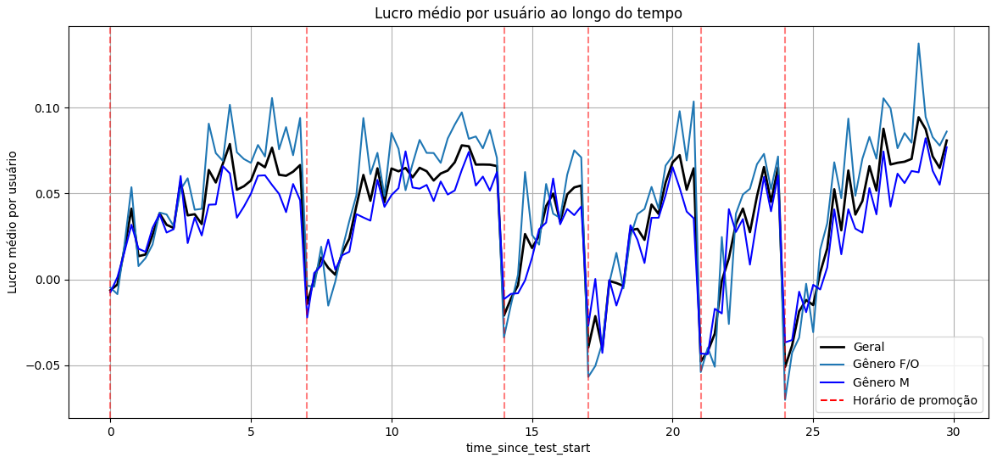

- Assim que um offerta era lançada, um forte estímulo de queda no lucro médio por usuário era sentido, gerando um vale.
- Conforme a média de clientes usando a oferta ia diminuindo, e também o período de vigencia ia se esgotando, o sinal tinha uma recuperação flutuante com tendencia de estagnação aparente, até que outro período de promoção inicia-se. 
- Conforme o período médio entre promoções se encurtou, houve sobreposições maiores de ofertas vigentes, e vales sucessivamente mais fundos, chegando a se ter períodos significativos de de prejuizo estimado. 
- Embora essa estratégia de distribuição abrupta de promoções não me agrade, pois dificulta o controle, essa configuração possível foi a utilizada para se modelar uma solução.
    - Mantendo-se mais parâmetros constantes, podemos economizar análises, eis o motivo.
    - Gostaria de ter tentado um modelo autoregressivo no tempo, o assunto me interessa, porém seria muito mais complicado para demonstrar minha aptidões. 

**Também vimos os seguinte comportamentos em função do número de ofertas recebidas pelos usuários**  
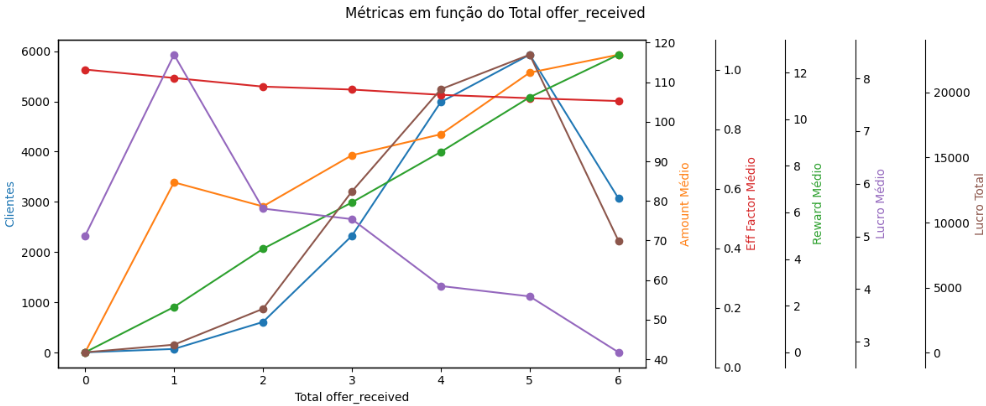

- Enquanto o engajamento quanto as compras aumenta (amount), acompanhado dos prêmios, observa-se queda no lucro médio por usuário, e na proporção entre amount/(amount+reward) = Eff. Esse fator, sendo abaixo do percentual passado para o ifood, torna-se prejuizo.
- O lucro bruto acompanha a distribuição de usuários, o que revela que mesmo com tantas flutuações nos dados, existe um valor medio por usuário que persisite com as aniquilaçoes de sinais positivos e negativos. Isto é, o saldo é positivo. 
- Quando o número de ofertas por usuário se aproxima de 6, o lucro médio por usuário (para esse grupo que recebe 6 ofertas) se aproxima de um valor critico de 88%. Não se sabe se o número de ofertas por usuário é truncado ai propositadamente, mas 12% é o valor repassado ao ifood nas compras n "Plano Básico" (Fonte: https://blog-parceiros.ifood.com.br/taxas-ifood/).
- Para simplificar o estudo, definiu-se o lucro em função disso, destina-se uma estratégia para otimizar o lucro médio por usuário de uma forma **sustentável**.
- Olhando para o gráfico acima, pode-se inferir de modo precipitado que o melhor cenário é aquele que libera 1 offerta por usuário. O primeiro ponto a se debater quanto a isso é a baixíssima amostragem de clientes que receberam apenas 1 cupom, o que torna a medida muito sensível e não confiável. 
    - Ademais e, principalemente, deve ter em mente que o Ifood representa todo um ecossistema envolvendo clientes, restaurantes, entregadores, etc. Dessa forma, o engajamento com a plataforma é vital para a saúde e longevidade da empresa. Uma queda no engajamento implica em uma cadeia de pessoas, e pode abrir espaço para crescimento de concorrência. Logo, toda estratégia é delicada, neste caso.

- Tendo esses princípior em mente, julgou-se adequado um ponto de equilíbrio entre o engajamento e o lucro por cliente, em um ponto com alguma amostragem signitivamente maior que o de 1 oferta por usuário:
    - o ponto de 3 ofertas por usuário, que possui uma expectativa de lucro maior do que a média observada nos dados e não compromete tanto o engajamento quanto valores inferiores.

- Após uma boa leitura do caso, percebeu-se a complexidade envolvida. Visando uma simplificação do problema este estudo realizado foi um estudo exploratório. Se o prazo permitisse, próximos passos naturais da pesquisa seriam dados.


In [6]:
# Leitura
path_uniao  = "../data/processed/silver/uniao.parquet"
df_uniao  = pd.read_parquet(path_uniao).dropna()

# recuperando promoçoes de accounts
offers_df = (
    df_uniao[df_uniao.event=='offer_received']
    .groupby("account_id")["label_offer"]
    .apply(list)
    .reset_index()
)

# Filtrando para dados de treino
offers_df = offers_df[offers_df['account_id'].isin(ids_train_total)]

# Encontrando o número de ofertas e separando os ids que possuem 3 (ponto de equilibrio)
offers_df['len'] = offers_df['label_offer'].apply(len)
offers_df3 = offers_df[offers_df.len==3]
idx_3 = offers_df3.account_id.tolist()

# Tendo uma noção da distribuição 
df3 = df[df.account_id.isin(idx_3)].copy().reset_index(drop=True)
df3['lucro'].describe()

count    1601.000000
mean        6.356232
std        12.879624
min       -16.370800
25%         0.583200
50%         3.105600
75%         9.491600
max       130.451200
Name: lucro, dtype: float64

In [7]:
# threshold definido 4.5
ids_to_inv = df3[df3['lucro']>=4.5]['account_id'].tolist()
offers_df3 = offers_df3[offers_df3['account_id'].isin(ids_to_inv)].copy()

# Escolha do grupo candidato
escolha_geral = offers_df3['label_offer'].apply(sorted).astype(str).value_counts().index[0]
escolha_geral

"['10', '6', '7']"

# Projeção de resultados grupo de treino
- os passos anteriores consistiram em gerar situações hipotíticas de distribuição de offertas sobre os dados de treino e avaliar com o modelo já treinado. Isso parece um pouco contraditório, ao se pensar que o modelo treinou com os próprios usuários. Entretanto, destacam-se 2 pontos:
    - 1 Os dados do usuário permanecem fixos, porém os relativos as ofertas não.
    - 2 Precisava-se de um meio de procurar por boas ofertas candidatas para usar nos usuários separados no conjunto de teste. Não se pode dizer que os resultados preditos vão efetivamente se consolidar, pois tratam-se de amostras sintéticas, mas não se pode dizer que o resultado no projetado no conjunto de teste foi otimizado sobre seus próprios dados, pois tanto o treinamento quando a especificação foi realizada com base nos dados de treino. 

In [ ]:
# Função que agrega o cenário testado aos dados pessoais do cliente
def build_df_agg_synthetic_scenario(df_profiles, df_offers, offer_list):
    """
    Constrói df_agg supondo que TODOS os perfis receberam exatamente as ofertas em offer_list.
    
    Parâmetros:
    -----------
    df_profiles : DataFrame
        Contém account_id e variáveis fixas do cliente.
    df_offers : DataFrame
        Contém as características de cada oferta (com 'label_offer').
    offer_list : list
        Lista de ofertas simuladas (ex: [4,5,8]).
    
    Retorna:
    --------
    df_agg : DataFrame
        Agregado por account_id, com soma/média/max conforme regras.
    """

    # Seleciona apenas as ofertas que queremos simular
    offers_selected = df_offers[df_offers["label_offer"].isin(offer_list)].copy()

    # Produto cartesiano: cada cliente × cada oferta da lista
    df_acc = df_profiles.copy().assign(key=1)
    df_off = offers_selected.assign(key=1)
    df_features = df_acc.merge(df_off, on="key").drop("key", axis=1)

    # -------------------------------
    # Agregação por conta
    # -------------------------------
    columns_to_keep_first = ['credit_card_limit', 'gender', 'dias_de_registro', 'anos_de_ifood', 'age']
    columns_to_get_mean = ['max_discount', 'discount_value', 'min_value', 'duration']
    columns_to_get_sum = ['social', 'mobile', 'web','offer_type_bogo', 'offer_type_discount', 
                          'offer_type_informational',"label_offer_1","label_offer_2","label_offer_3",
                          "label_offer_4", "label_offer_5","label_offer_6","label_offer_7",
                          "label_offer_8", "label_offer_9","label_offer_10"]

    # soma
    df_sum_agg = df_features.groupby("account_id")[columns_to_get_sum].sum()
    # média
    df_mean_agg = df_features.groupby("account_id")[columns_to_get_mean].mean()
    # atributos fixos
    df_remain_agg = df_features.groupby("account_id")[columns_to_keep_first].max()

    # juntar tudo
    df_agg = pd.concat([df_sum_agg, df_mean_agg, df_remain_agg], axis=1).dropna().reset_index()
    df_agg["n_off"] = int(len(offer_list))

    return df_agg

# Criação dos dados sintéticos no conjunto de treino e medições

In [9]:
from src.projeto import get_offer_formated, build_df_agg_synthetic_scenario

# Load_model
base_dir=".."
model_name="random_forest_model.pkl"
models_dir = os.path.join(base_dir, "models")
model_path = os.path.join(models_dir, model_name)

# model 
model = joblib.load(model_path)

# Profile (features independentes de oferta)
df_profile = df[[ 'account_id', 'credit_card_limit', 'gender', 'dias_de_registro', 'anos_de_ifood', 'age']]
df_profile_test = df_profile[df_profile['account_id'].isin(ids_test)].reset_index(drop=True)
df_profile_train = df_profile[df_profile['account_id'].isin(ids_train_total)].reset_index(drop=True)


df_offers_silver = get_offer_formated()
df_offers_silver

,label_offer,max_discount,discount_value,min_value,duration,social,mobile,web,offer_type_bogo,offer_type_discount,...,label_offer_1,label_offer_2,label_offer_3,label_offer_4,label_offer_5,label_offer_6,label_offer_7,label_offer_8,label_offer_9,label_offer_10
0,1,1.00,10,10,7.0,1,1,0,1,0,...,1,0,0,0,0,0,0,0,0,0
1,2,1.00,10,10,5.0,1,1,1,1,0,...,0,1,0,0,0,0,0,0,0,0
2,3,1.00,5,5,7.0,0,1,1,1,0,...,0,0,1,0,0,0,0,0,0,0
3,4,1.00,5,5,5.0,1,1,1,1,0,...,0,0,0,1,0,0,0,0,0,0
4,5,0.43,3,7,7.0,1,1,1,0,1,...,0,0,0,0,1,0,0,0,0,0
5,6,0.25,5,20,10.0,0,0,1,0,1,...,0,0,0,0,0,1,0,0,0,0
6,7,0.20,2,10,10.0,1,1,1,0,1,...,0,0,0,0,0,0,1,0,0,0
7,8,0.20,2,10,7.0,0,1,1,0,1,...,0,0,0,0,0,0,0,1,0,0
8,9,0.00,0,0,4.0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,1,0
9,10,0.00,0,0,3.0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [ ]:
# Contruindo um cenário sintético
synthetic_offers = [int(x)for x in eval(escolha_geral)]
df_train_scenario = build_df_agg_synthetic_scenario(df_profile_train, df_offers_silver, synthetic_offers)
print(df_train_scenario.shape)
display(df_train_scenario.head())

(11856, 27)


,account_id,social,mobile,web,offer_type_bogo,offer_type_discount,offer_type_informational,label_offer_1,label_offer_2,label_offer_3,...,max_discount,discount_value,min_value,duration,credit_card_limit,gender,dias_de_registro,anos_de_ifood,age,n_off
0,0011e0d4e6b944f998e987f904e8c1e5,2,2,2,0,2,1,0,0,0,...,0.15,2.333333,10.0,7.666667,57000.0,1,195,0,40,3
1,0020c2b971eb4e9188eac86d93036a77,2,2,2,0,2,1,0,0,0,...,0.15,2.333333,10.0,7.666667,90000.0,1,871,2,61,3
2,0020ccbbb6d84e358d3414a3ff76cffd,2,2,2,0,2,1,0,0,0,...,0.15,2.333333,10.0,7.666667,60000.0,1,619,1,25,3
3,003d66b6608740288d6cc97a6903f4f0,2,2,2,0,2,1,0,0,0,...,0.15,2.333333,10.0,7.666667,73000.0,1,397,1,27,3
4,00426fe3ffde4c6b9cb9ad6d077a13ea,2,2,2,0,2,1,0,0,0,...,0.15,2.333333,10.0,7.666667,65000.0,1,713,1,20,3


In [ ]:
cols = df.columns.tolist()
cols.remove('lucro'), cols.remove('account_id')
df_train_total = df[df['account_id'].isin(ids_train_total)].copy()

# mean pred
train_sythetic_predict = model.predict(df_train_scenario[cols].values)
train_pred = float(round(np.mean(train_sythetic_predict),3))
train_real = float(round(df_train_total['lucro'].sum()/len(df_train_total['account_id'].unique())))

print(f'Média de lucro por cliente por mes treino: {train_real}')
print(f'Nova média com promoção equilibrada: {train_pred}')
print(f'Aumento: {100*(train_pred/train_real):.2f}%')

Média de lucro por cliente por mes treino: 4.0
Nova média com promoção equilibrada: 9.914
Aumento: 247.85


# Dados de teste
- Projeção sobre os dados de teste

In [22]:
df_test_scenario = build_df_agg_synthetic_scenario(df_profile_test, df_offers_silver, synthetic_offers)
print(df_test_scenario.shape)
display(df_test_scenario.head())

(2964, 27)


,account_id,social,mobile,web,offer_type_bogo,offer_type_discount,offer_type_informational,label_offer_1,label_offer_2,label_offer_3,...,max_discount,discount_value,min_value,duration,credit_card_limit,gender,dias_de_registro,anos_de_ifood,age,n_off
0,0009655768c64bdeb2e877511632db8f,2,2,2,0,2,1,0,0,0,...,0.15,2.333333,10.0,7.666667,72000.0,0,458,1,34,3
1,004b041fbfe44859945daa2c7f79ee64,2,2,2,0,2,1,0,0,0,...,0.15,2.333333,10.0,7.666667,74000.0,1,76,0,55,3
2,004c5799adbf42868b9cff0396190900,2,2,2,0,2,1,0,0,0,...,0.15,2.333333,10.0,7.666667,99000.0,0,844,2,56,3
3,00b3c376db2a4115af3aef34a02f61d6,2,2,2,0,2,1,0,0,0,...,0.15,2.333333,10.0,7.666667,104000.0,0,391,1,51,3
4,00bbce6533f44ddeaf4dd32bcab55441,2,2,2,0,2,1,0,0,0,...,0.15,2.333333,10.0,7.666667,50000.0,0,1333,3,97,3


In [23]:
cols = df.columns.tolist()
cols.remove('lucro'), cols.remove('account_id')
df_test_total = df[df['account_id'].isin(ids_test)].copy()

# mean pred
test_sythetic_predict = model.predict(df_test_scenario[cols].values)
test_pred = float(round(np.mean(test_sythetic_predict),3))
test_real = float(round(df_test_total['lucro'].sum()/len(df_test_total['account_id'].unique())))

print(f'Média de lucro por cliente por mes treino: {test_real}')
print(f'Nova média com promoção equilibrada: {test_pred}')
print(f'Aumento: {100*(test_pred/test_real):.2f}%')

Média de lucro por cliente por mes treino: 5.0
Nova média com promoção equilibrada: 9.854
Aumento: 197.08%


# Conclusão :
- Embora desvios significativos foram observados, o resultado sobre os 2 datasets teve uma resposta projetada bem positiva (250 ou 200% do valor médio medido nos dados reais).
- Na configuração escolhida sobre o ponto de equilíbrio com ofertas potenciais, todas as pessoas recebem os mesmos cupoms.
- A disposição temporal escolhida foi 0, 14 e 24d. Seguindo as opções possíveis.
    - Contudo, na prática da vida real, eu sugeriria o monitoramento contínuo dessas medidas para que qualquer tomada de decisão possa ser tomada em tempo hábil.
    - Cenários abrutos proporcionam maiores riscos que cenários controlados. A entrega distribuida de modo mais uniforme proporciona, além de maior suavidade, um menor risco a sinistros.
        - Imagine que um cupom que era pra ser de 10 reais vai como 1000 reais. Caso a distribuição não fosse pontual e abrupta, haveria menos impacto devido ao tempo de correção.
    - Neste notebook o conjunto de dados utilizado já desconsidera as countas que não tinham informações de cadastro (cartao, genero e idade) e eram mais "insensíveis" aos sinais de promoções.
- Acredita-se que, em caso de sucesso na estratégia, deva-se continuar e fomentar ofertas, tanto para pesquisa de público, quanto para estimulação do ecossistema. Os dados mostraram que existe uma parcela de contas criadas em menos de 1 ano que é menos ativa, mas isso logo vai mudando quando os clientes atingem 2 a 3 anos de casa. Clientes mais antigos, proporcionalmente, dão respostas piores que esses intermediários, a investigação desse fenômeno pode ser util e interessante para empresa.

juliopatti@gmail.com